In [2]:
import pandas as pd 
import numpy as np 
from plotnine import *
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_predict

In [3]:
ha = pd.read_csv("https://www.dropbox.com/s/aohbr6yb9ifmc8w/heart_attack.csv?dl=1")
ha.head()

#sex, cp, restecg, output will need to be dummified 

,age,sex,cp,trtbps,chol,restecg,thalach,output
0,63,1,3,145,233,0,150,1
1,37,1,2,130,250,1,187,1
2,56,1,1,120,236,1,178,1
3,57,0,0,120,354,1,163,1
4,57,1,0,140,192,1,148,1


## Part One: Fitting Models
This section asks you to create a final best model for each of the model types studied this week. For each, you should:

Find the best model based on ROC AUC for predicting the target variable.

Report the (cross-validated!) ROC AUC metric.

Fit the final model.

Output a confusion matrix; that is, the counts of how many observations fell into each predicted class for each true class.

(Where applicable) Interpret the coefficients and/or estimates produced by the model fit.

You should certainly try multiple model pipelines to find the best model. You do not need to include the output for every attempted model, but you should describe all of the models explored. You should include any hyperparameter tuning steps in your writeup as well.

#### Which predictors were most important to predicting heart attack risk? (output)

#### Q1: KNN

In [4]:
X = ha.drop(["output"], axis = 1)
y = ha["output"]
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [5]:
#KNN 

ct = ColumnTransformer(
  [
    ("dummify",
    OneHotEncoder(sparse_output = False, handle_unknown='ignore'),
    make_column_selector(dtype_include = object)),
    ("standardize",
    StandardScaler(),
    make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
)

#KNN 5
knn_pipeline = Pipeline(
  [("preprocessing", ct),
  ("knn",  KNeighborsClassifier())]
).set_output(transform = "pandas")

In [12]:
# tune hyperparameter k
param_grid1 = {
    "knn__n_neighbors": [2, 5, 8, 10, 15, 18, 20, 25, 30, 35, 40, 45, 50, 55, 60, 100]
}

knn_grid_search = GridSearchCV(knn_pipeline, param_grid1, cv=5, scoring='roc_auc')

knn_grid_search.fit(X_train, y_train)
print("best_params", knn_grid_search.best_params_)

best_params {'knn__n_neighbors': 35}


In [14]:
knn_pipeline.set_params(knn__n_neighbors = 35)

knn_pipeline.fit(X_train, y_train)
y_pred = cross_val_predict(knn_pipeline, X_test, y_test, cv=5)

cm = confusion_matrix(y_test, y_pred)
cm

array([[16, 14],
       [ 1, 38]], dtype=int64)

In [15]:
#print(accuracy_score(y, y_pred))
print("roc auc for knn:", roc_auc_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

roc auc for knn: 0.7538461538461538
              precision    recall  f1-score   support

           0       0.94      0.53      0.68        30
           1       0.73      0.97      0.84        39

    accuracy                           0.78        69
   macro avg       0.84      0.75      0.76        69
weighted avg       0.82      0.78      0.77        69



In [16]:
#logistic regression 
param_gridlr = {'logr__C': [0.01, 0.1, 1, 10, 100]}

logr_pipeline = Pipeline(
  [("preprocessing", ct),
  ("logr",  LogisticRegression())]
).set_output(transform = "pandas")

logr_grid_search = GridSearchCV(logr_pipeline, param_gridlr, cv = 5, scoring = 'roc_auc')

logr_grid_search.fit(X_train,y_train)
print("best_params", logr_grid_search.best_params_)

best_params {'logr__C': 0.01}


In [17]:
logr_pipeline.set_params(logr__C = .01)

logr_pipeline.fit(X_train, y_train)
y_pred3 = cross_val_predict(logr_pipeline, X_test, y_test, cv=5)

cm3 = confusion_matrix(y_test, y_pred3)
cm3

array([[12, 18],
       [ 0, 39]], dtype=int64)

In [19]:
print("roc auc for logr:", roc_auc_score(y_test, y_pred3))
print(classification_report(y_test, y_pred3))

roc auc for logr: 0.7
              precision    recall  f1-score   support

           0       1.00      0.40      0.57        30
           1       0.68      1.00      0.81        39

    accuracy                           0.74        69
   macro avg       0.84      0.70      0.69        69
weighted avg       0.82      0.74      0.71        69



In [20]:
#Decision Tree
param_grid2 = {
    'dtree__max_depth': [3, 5, 10],
    'dtree__min_samples_split': [2, 5, 10],
    'dtree__min_samples_leaf': [1, 2, 4]
}
dtree_pipeline = Pipeline(
  [("preprocessing", ct),
  ("dtree",  DecisionTreeClassifier())]
).set_output(transform = "pandas")

dtree_grid_search = GridSearchCV(dtree_pipeline, param_grid2, cv=5, scoring='roc_auc')

dtree_grid_search.fit(X_train, y_train)
print("best_params", dtree_grid_search.best_params_)

best_params {'dtree__max_depth': 5, 'dtree__min_samples_leaf': 2, 'dtree__min_samples_split': 5}


In [21]:
dtree_pipeline.set_params(dtree__max_depth = 5, dtree__min_samples_leaf = 2, dtree__min_samples_split = 5)

dtree_pipeline.fit(X_train, y_train)
y_pred2 = cross_val_predict(dtree_pipeline, X_test, y_test, cv=5)

cm = confusion_matrix(y_test, y_pred2)
cm

array([[23,  7],
       [ 9, 30]], dtype=int64)

In [22]:
print("roc auc for dtree:", roc_auc_score(y_test, y_pred2))
print(classification_report(y_test, y_pred2))

roc auc for dtree: 0.7679487179487179
              precision    recall  f1-score   support

           0       0.72      0.77      0.74        30
           1       0.81      0.77      0.79        39

    accuracy                           0.77        69
   macro avg       0.76      0.77      0.77        69
weighted avg       0.77      0.77      0.77        69



In [23]:
#dtree importances
best_dtree = dtree_grid_search.best_estimator_.named_steps['dtree']

if hasattr(ct, "get_feature_names_out"):
    feature_names = ct.get_feature_names_out()
else:
    feature_names = X_train.columns  # Fallback if no transformations were applied

importances = best_dtree.feature_importances_
feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
feature_importances

,Feature,Importance
2,standardize__cp,0.339354
3,standardize__trtbps,0.200336
1,standardize__sex,0.132552
0,standardize__age,0.126760
6,standardize__thalach,0.117086
4,standardize__chol,0.083913
5,standardize__restecg,0.000000


In [24]:
#logr importances
best_logr = logr_grid_search.best_estimator_.named_steps['logr']

if hasattr(ct, "get_feature_names_out"):
    feature_names = ct.get_feature_names_out()
else:
    feature_names = X_train.columns 

importances2 = best_logr.coef_[0]  

feature_importances2 = pd.DataFrame({'Feature': feature_names, 'Importance': importances2})
feature_importances2 = feature_importances2.sort_values(by='Importance', ascending=False)
feature_importances2

,Feature,Importance
6,standardize__thalach,0.216216
2,standardize__cp,0.209433
5,standardize__restecg,0.081910
4,standardize__chol,-0.065369
3,standardize__trtbps,-0.081839
0,standardize__age,-0.146883
1,standardize__sex,-0.200835


In [25]:
#knn importances 
from sklearn.inspection import permutation_importance

# Compute permutation importance: method referenced from Chat 4o. Goal being to compare the coefficients in a similar way to best_dtree and best_logr models
result = permutation_importance(knn_pipeline, X_train, y_train, scoring="roc_auc", n_repeats=10, random_state=42)

importances3 = result.importances_mean  
if hasattr(ct, "get_feature_names_out"):
    feature_names = ct.get_feature_names_out()
else:
    feature_names = X_train.columns

feature_importances3 = pd.DataFrame({'Feature': feature_names, 'Importance': importances3})
feature_importances3 = feature_importances3.sort_values(by='Importance', ascending=False)

# Display feature importances
feature_importances3

,Feature,Importance
2,standardize__cp,0.064245
1,standardize__sex,0.061610
6,standardize__thalach,0.061490
0,standardize__age,0.022931
5,standardize__restecg,0.020681
4,standardize__chol,0.007101
3,standardize__trtbps,0.006234


## Q4: Interpretation

Which predictors were most important to predicting heart attack risk? 

*top 3 from each model*

Most important predictors from: 

KNN: cp, thalach, sex

Dtree: CP, trtbps, sex

LogR: CP, thalach, sex

## Q5: ROC Curve

Plot the ROC Curve for your three models above.

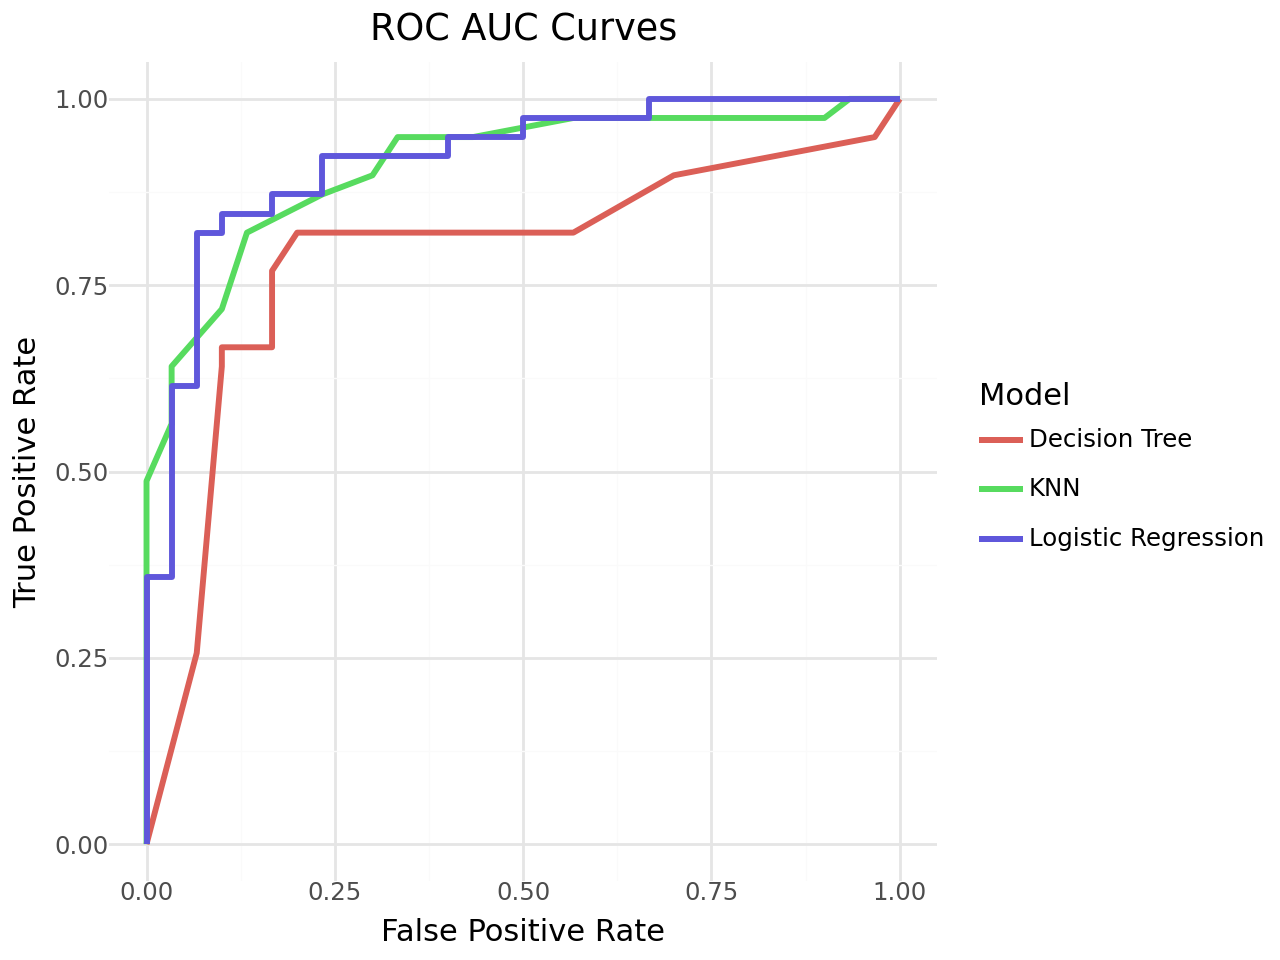

In [26]:
#plot 
from sklearn.metrics import roc_curve

models = {
    "Logistic Regression": logr_pipeline,
    "Decision Tree": dtree_pipeline,
    "KNN": knn_pipeline,
}

roc_data = []

for model_name, pipeline in models.items():
    pipeline.fit(X_train, y_train)
    y_proba = pipeline.predict_proba(X_test)[:, 1]  
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc = roc_auc_score(y_test, y_proba)
    
    roc_data.extend(
        {"fpr": fpr_val, "tpr": tpr_val, "model": model_name, "auc": auc}
        for fpr_val, tpr_val in zip(fpr, tpr)
    )

roc_df = pd.DataFrame(roc_data)

(ggplot(roc_df, aes(x="fpr", y="tpr", color="model"))
 + geom_line(size=1.2)
 + labs(title="ROC AUC Curves",
    x="False Positive Rate",
    y="True Positive Rate",
    color="Model") 
 + theme_minimal()
)


## Part Two: Metrics

Consider the following metrics:

True Positive Rate or Recall or Sensitivity = Of the observations that are truly Class A, how many were predicted to be Class A?

Precision or Positive Predictive Value = Of all the observations classified as Class A, how many of them were truly from Class A?

True Negative Rate or Specificity or Negative Predictive Value = Of all the observations classified as NOT Class A, how many were truly NOT Class A?

Compute each of these metrics (cross-validated) for your three models (KNN, Logistic Regression, and Decision Tree) in Part One.

In [28]:
# cv metrics calculated in confusion matrices above, I believe. The following function is for practice/redundancy
metrics_results = {}

models = {
    "Logistic Regression": logr_pipeline,
    "Decision Tree": dtree_pipeline,
    "KNN": knn_pipeline,
}

for model_name, pipeline in models.items():
    y_pred = cross_val_predict(pipeline, X, y, cv=5)
    
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel() #line referenced from Chat 4o
    
    recall = tp / (tp + fn) 
    precision = tp / (tp + fp)  
    specificity = tn / (tn + fp) 
    
    metrics_results[model_name] = {
        "Recall": recall,
        "Precision": precision,
        "Specificity ": specificity,
    }

#f for formatted string, rounded to 5 decimal places
for model, metrics in metrics_results.items():
    print(f"Metrics for {model}:")
    for metric_name, value in metrics.items():
        print(f"  {metric_name}: {value:.5f}")
    print()

Metrics for Logistic Regression:
  Recall: 0.86986
  Precision: 0.74269
  Specificity : 0.65354

Metrics for Decision Tree:
  Recall: 0.65753
  Precision: 0.74419
  Specificity : 0.74016

Metrics for KNN:
  Recall: 0.82192
  Precision: 0.74074
  Specificity : 0.66929



## Part Three: Discussion

Suppose you have been hired by a hospital to create classification models for heart attack risk.

The following questions give a possible scenario for why the hospital is interested in these models. For each one, discuss:

Which metric(s) you would use for model selection and why.

Which of your final models (Part One Q1-3) you would recommend to the hospital, and why.

What score you should expect for your chosen metric(s) using your chosen model to predict future observations.

### Q1

The hospital faces severe lawsuits if they deem a patient to be low risk, and that patient later experiences a heart attack.

In [ ]:
#Recall:  the proportion of actual high-risk patients that the model correctly identifies as high risk.
#Precision:the proportion of patients predicted to be high risk who are actually high risk.
#Sensitivity:the proportion of actual low-risk patients (those unlikely to have a heart attack) that the model correctly identifies as low risk.

In this situation, I would use the Recall metric for model selection, because we need to avoid false negatives. Recall measures the proportion of actual high-risk patients that the model correctly identifies as high risk, which is what the hospital needs to maximize in order to avoid lawsuits. 

For this situation, the best model to use would be the log regression, because it has the highest cross validated recall score.
We should expect a recalll score of .87.

### Q2

The hospital is overfull, and wants to only use bed space for patients most in need of monitoring due to heart attack risk.

In this situation, I would use the precision score metric to determine model selection, because we need to know the proportion of patients predicted to be high risk, who are actually high risk. Precision is important to this situation, compared to recall and sensitivity, because the hospital wants to ensure that limited bed space is only used for those truly in need.

For this situation, the best model to use would be the Decision Tree, because it has the highest precision score of the three models, but only slightly. 
We should expect a precision score of .74.


### Q3

The hospital is studying root causes of heart attacks, and would like to understand which biological measures are associated with heart attack risk.

In this situation, I would use the recall score to determine model selection, because the hospital wants to include as many true high-risk cases as possible for studying risk factors. Because of this, it is most important to maximize the true positive rate of high risk patients. 

For this situation, the best model to use would be the log regression, because it has the highest cross validated recall score.
We should expect a recall score of .87. 

### Q4

The hospital is training a new batch of doctors, and they would like to compare the diagnoses of these doctors to the predictions given by the algorithm to measure the ability of new doctors to diagnose patients.

In this situation, I would use the precision score to determine model selection, because we need accurate benchmarks for comparing the ability of new doctors. However, recall and specificity could also be used here for wholistic comparison. 

For this situation, the best model to use would be the Decision Tree model because it has the highest precision score. 
We should expect a precision score of .74.

## Part Four: Validation

Before sharing the dataset with you, I set aside a random 10% of the observations to serve as a final validation set.

ha_validation = pd.read_csv("https://www.dropbox.com/s/jkwqdiyx6o6oad0/heart_attack_validation.csv?dl=1")

Use each of your final models in Part One Q1-3, predict the target variable in the validation dataset.

For each, output a confusion matrix, and report the ROC AUC, the precision, and the recall.

Compare these values to the cross-validated estimates you reported in Part One and Part Two. Did our measure of model success turn out to be approximately correct for the validation data?

In [30]:
ha_validation = pd.read_csv("https://www.dropbox.com/s/jkwqdiyx6o6oad0/heart_attack_validation.csv?dl=1")
ha_validation.head()

,age,sex,cp,trtbps,chol,restecg,thalach,output
0,41,0,1,130,204,0,172,1
1,64,1,3,110,211,0,144,1
2,59,1,0,135,234,1,161,1
3,42,1,0,140,226,1,178,1
4,40,1,3,140,199,1,178,1


In [31]:
Xf = ha_validation.drop(["output"], axis = 1)
yf = ha_validation["output"]

In [36]:
#logr
y_predf = logr_pipeline.predict(Xf)
print("validated roc auc for logr:", roc_auc_score(yf, y_predf))
print(classification_report(yf, y_predf))
print(confusion_matrix(yf, y_predf))

validated roc auc for logr: 0.8755980861244018
              precision    recall  f1-score   support

           0       0.77      0.91      0.83        11
           1       0.94      0.84      0.89        19

    accuracy                           0.87        30
   macro avg       0.86      0.88      0.86        30
weighted avg       0.88      0.87      0.87        30

[[10  1]
 [ 3 16]]


In [44]:
#knn
knn_pipeline.set_params(knn__n_neighbors=5)

y_predf1 = knn_pipeline.predict(Xf)
print("validated roc auc for knn:", roc_auc_score(yf, y_predf1))
print(classification_report(yf, y_predf1))
print(confusion_matrix(yf, y_predf1))

validated roc auc for knn: 0.6794258373205742
              precision    recall  f1-score   support

           0       0.53      0.73      0.62        11
           1       0.80      0.63      0.71        19

    accuracy                           0.67        30
   macro avg       0.67      0.68      0.66        30
weighted avg       0.70      0.67      0.67        30

[[ 8  3]
 [ 7 12]]


In [47]:
#Dtree

y_predf2 = dtree_pipeline.predict(Xf)
print("validated roc auc for dtree:", roc_auc_score(yf, y_predf2))
print(classification_report(yf, y_predf2))
print(confusion_matrix(yf, y_predf2))

validated roc auc for dtree: 0.7248803827751196
              precision    recall  f1-score   support

           0       0.56      0.82      0.67        11
           1       0.86      0.63      0.73        19

    accuracy                           0.70        30
   macro avg       0.71      0.72      0.70        30
weighted avg       0.75      0.70      0.71        30

[[ 9  2]
 [ 7 12]]


In [46]:
metrics_results = {}

models = {
    "Logistic Regression": logr_pipeline,
    "Decision Tree": dtree_pipeline,
    "KNN": knn_pipeline,
}

for model_name, pipeline in models.items():
    y_pred = cross_val_predict(pipeline, Xf, yf, cv=5)
    
    tn, fp, fn, tp = confusion_matrix(yf, y_pred).ravel() #line referenced from Chat 4o
    
    recall = tp / (tp + fn) 
    precision = tp / (tp + fp)  
    specificity = tn / (tn + fp) 
    
    metrics_results[model_name] = {
        "Recall": recall,
        "Precision": precision,
        "Specificity ": specificity,
    }

#f for formatted string, rounded to 5 decimal places
for model, metrics in metrics_results.items():
    print(f"Metrics for {model}:")
    for metric_name, value in metrics.items():
        print(f"  {metric_name}: {value:.5f}")
    print()

Metrics for Logistic Regression:
  Recall: 1.00000
  Precision: 0.63333
  Specificity : 0.00000

Metrics for Decision Tree:
  Recall: 0.78947
  Precision: 0.68182
  Specificity : 0.36364

Metrics for KNN:
  Recall: 1.00000
  Precision: 0.73077
  Specificity : 0.36364



##### Compare these values to the cross-validated estimates you reported in Part One and Part Two. Did our measure of model success turn out to be approximately correct for the validation data?

Logr model: 
- roc auc increased from .7 to .88
- recall increased from .87 to 1.0
- precision decreased from .74 to .63 <br>
While the model improved in terms of identifying all high-risk patients (Recall), the tradeoff in Precision may require addressing if false positives are costly or problematic.

Dtree model: 
- roc auc decreased from .77 to .72
- recall increased from .66 to .79
- precision decreased from .74 to .68 <br>
While it improved in Recall, its lower ROC AUC and Precision suggest it may be less reliable overall for generalization.

KNN model:

*knn model in validation test is not tuned to the trained pipeline parameters. this is because the validation test data sample size does not support 35 n neighbors*
- roc auc decreased from .75 to .68 
- recall increased from .82 to 1.0 
- precision decreased from .74 to .73
Results are not valid/comparable, due to the disjoint hyperparameters.

## Part Five: Cohen’s Kappa
Another common metric used in classification is Cohen’s Kappa.

Use online resources to research this measurement. Calculate it for the models from Part One, Q1-3, and discuss reasons or scenarios that would make us prefer to use this metric as our measure of model success. Do your conclusions from above change if you judge your models using Cohen’s Kappa instead? Does this make sense?

In [49]:
from sklearn.metrics import cohen_kappa_score
knn_pipeline.set_params(knn__n_neighbors=35)  

models = {
    "Logistic Regression": logr_pipeline,
    "Decision Tree": dtree_pipeline,
    "KNN": knn_pipeline,
}

kappa_scores = {}

for model_name, pipeline in models.items():
    y_pred = cross_val_predict(pipeline, X, y, cv=5)
    kappa = cohen_kappa_score(y, y_pred)
    kappa_scores[model_name] = kappa

# Display results
for model, kappa in kappa_scores.items():
    print(f"Cohen Kappa for {model}: {kappa:.3f}")

Cohen Kappa for Logistic Regression: 0.530
Cohen Kappa for Decision Tree: 0.394
Cohen Kappa for KNN: 0.495


"Cohen’s Kappa is a statistical metric used to measure the level of agreement between two raters or predictors, taking into account the possibility of agreement occurring by chance" - Stack Exchange

Cohen's Kappa could be preferable to roc_auc, precision, recall when there is a "severe class imbalance", in which agreement (kappa) should be highly considered. The order of Kappa values follow the order of the original recall scores of the 3 models, suggesting that class imbalance is unlikely in this context. Therefore, our conclusions are roughly unchanged from the analysis already performed. 
It does make sense for Cohen's Kappa to follow the recall score order because the 2 metrics follow the same indicators for class imbalanced data.